<a href="https://colab.research.google.com/github/simsekergun/MoS2/blob/main/MoS2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Complex Electrical Permittivity of Monolayer MoS<sub>2</sub>
This notebook calculates the refractive index and/or complex electrical permittivity and/or conductivity of monolayer MoS2 as functions of wavelength (m), Fermi Energy level (eV), and temperature (K), in the visible and near-infrared parts of the electromagnetic spectrum (400 nm - 1.2 um)

If you use this code or its [MATLAB version](https://github.com/simsekergun/MoS2/blob/main/getMoS2epsnk.m), please cite the following reference.

B. Mukherjee, F. Tseng, D. Gunlycke, K. K. Amara, G. Eda, and E. Simsek, "Complex electrical permittivity of the monolayer molybdenum disulfide (MoS2) in near UV and visible," Optical Materials Express, vol. 5, no. 2, pp. 447-455 (2015). [Download](https://www.csee.umbc.edu/~simsek/journal_papers/j30_sci_rep.pdf)

In [1]:
def getMoS2epsnk(wavelength = 600e-9,Ef = 0.0,Temp = 300): 
    import numpy as np
    a = np.array([200890.0,57534.0,81496.0,82293.0,331300.0,4390600.0,0.010853,0.059099,0.11302,0.11957,0.28322,0.78515,23.224,2.7982,0.30893])
    NX = 6   # number of lorentzians
    xd = wavelength * 1000000000.0
    Esall = get_eigens_mos2(0,Temp,NX)
    Esa = np.append(Esall[0:NX-2],4.34)
    Esa = np.insert(Esa,0,0.0)
    b = a2b(a,Ef,Temp)
    wavelength = np.asarray(wavelength)
    if wavelength.size ==1:
       eps = getepsEfsingle(b,Esa,Ef,Temp,wavelength,6)
    else:  
       eps = np.zeros(len(wavelength),dtype=np.complex)
       for ii in np.arange(len(wavelength)):              
          eps[ii] = getepsEfsingle(b,Esa,Ef,Temp,wavelength[ii],6)
    
    return eps
    ##########################################################################
    
def getepsEfsingle(params = None,Esas = None,Ef = None,Temp = None,xdata = None,nn = None): 
    import numpy as np
    from numpy import pi
    ehbar = 1519250349719305.0
    omegap = 0.0046075 * ehbar
    fs = params[0:nn].reshape(-1)
    gs = params[nn:2*nn].reshape(-1)* ehbar
    os = Esas * ehbar
    EeV = 1.24e-06 / xdata
    kbT = 8.621738e-05 * Temp
    d = np.exp(- (2 * Ef - kbT) ** 2 / 2 * 300)
    a_s = params[2 * nn]
    b_s = params[2 * nn + 1]
    c_s = params[2 * nn + 2]
    epsgi = a_s * np.exp(- (EeV - b_s + kbT) ** 2 / 2 / c_s ** 2)
    oml = 1883651567.308853 * (xdata ** (- 1))
    epsmos2 = 4.44+0j
    for mm in np.arange(nn):
        epsmos2 = epsmos2 + fs[mm]*(omegap ** 2.0) * (os[mm] ** 2 - oml ** 2 - 1j * gs[mm]*oml) ** (- 1)
    
    epsmos2 = epsmos2 + 1j * epsgi
    EeVi = np.array([np.linspace(- 100.0,EeV - 0.01,20000),np.linspace(EeV + 0.01,100,20000)])
    epsi = a_s * np.exp(- (EeVi - b_s + kbT) ** 2 / 2 / c_s ** 2)
    carp = np.trapz((EeVi*epsi/(EeVi ** 2 - EeV ** 2)).reshape(-1),EeVi.reshape(-1))
    epsr = carp / pi
    
    epsmos2 = epsmos2 + epsr
    return epsmos2
    ##########################################################################
    
def a2b(a = None,Ef = None,Temp = None): 
    import numpy as np
    kbT = 8.621738e-05 * Temp
    ddd = np.exp(- (2 * Ef - kbT)** 2 / (8.621738e-05 * 300))
    b = a
    b[1] = b[1] * (ddd**4)
    b[2] = b[2] * ddd
    b[3] = b[3] * ddd
    b[4] = b[4] * ddd
    b[7] = b[7] / ddd
    b[8] = b[8] / ddd
    b[9] = b[9] / ddd
    b[10] = b[10] / ddd
    return b
    ##########################################################################
    
def convertV2Ef(Vg = None): 
    import numpy as np
    from numpy import pi    
    hbar_eVs = 6.5821192815e-16    
    e_mass = 9.10938188e-31    
    Cg = 0.00012
    
    Ef = hbar_eVs ** 2 * pi * Cg * (Vg + 107) / (2 * 0.35 * e_mass)
    return Ef
    ##########################################################################
    
def eps2nk(eps_mat = None): 
    import numpy as np
    r_mat = np.real(eps_mat)
    i_mat = np.imag(eps_mat)
    n = np.sqrt(0.5 * (np.sqrt(r_mat ** 2 + i_mat ** 2) + r_mat))
    k = np.sqrt(0.5 * (np.sqrt(r_mat ** 2 + i_mat ** 2) - r_mat))
    return n, k
    ##########################################################################
    
def get_eigens_mos2(Ef = None,Temp = None,NX = None): 
    import numpy as np
    from numpy import pi
    from scipy.linalg import block_diag
    from numpy import linalg as LA
    from scipy.spatial import Delaunay
    # Constants
    hbar = 1.05457172647e-34    
    e_c = 1.60217656535e-19
    c = 299792458.0
    e_mass = 9.10938188e-31
    eps0 = 8.854187817e-12    
    mu0 = 4e-07 * np.pi    
    a0 = 4 * np.pi * eps0 * hbar ** 2 / e_mass / e_c ** 2    
    Ry = 13.605692533    
    #__________________________ Variables __________________________________
    m = e_mass * 0.32    
    a_lattice0 = 3.16e-10    
    ESO = 0.152 - Ef    
    epsr = 2.5    
    E1sa = 1.886
    kT = 8.621738e-05 * Temp
    a_lattice = a_lattice0
    a0 = a0 / np.tanh(1.1 / (np.multiply(8.621738e-05,Temp)) ** 0.25)
    # Mesh Creation
    x,y = np.meshgrid((np.arange(-NX,NX+1)) * a_lattice / 2,((np.arange(-NX-1,NX+2))) * a_lattice * np.sqrt(3) / 2)
    px,py = x.shape
    xi,yi = np.meshgrid(np.arange(1,px+1),np.arange(1,py+1))
    A = np.ones(xi.shape)
    A[np.mod(xi + yi,2)==0]=0
    xs = x.flatten()
    ys = y.flatten()
    As = A.flatten()
    mask = np.ones(len(xs), dtype=bool)
    mask[As == 0] = False
    xs = xs[mask]
    ys = ys[mask]
    mask = np.ones(len(xs), dtype=bool)
    mask[np.sqrt(xs ** 2 + ys ** 2) > a_lattice * NX / 2] = False    
    xs = xs[mask]
    ys = ys[mask]
    
    # Initialization
    nj = len(xs)    
    zeroj = np.argwhere((xs == 0) & (ys == 0))
    # Diagonal terms
    H = np.diag(- 2 * a0 * Ry / epsr / np.sqrt(xs ** 2 + ys ** 2)+0j)
    # Singularity treatment
    H[zeroj,zeroj] = - 2 * a0 * Ry / epsr / a_lattice
    
    # Single Particle Contributions
    for jj in np.arange(0,nj).reshape(-1):
        rs = np.sqrt((xs[jj] - xs) ** 2 + (ys[jj] - ys) ** 2)
        asd = np.argwhere(rs < 1.01 * a_lattice).reshape(-1)
        H[jj,asd] = H[jj,asd] + 2 * Ry / 3 * e_mass / m * (a0 / a_lattice) ** 2 + 1j * ESO / 9 * np.sin(4 * pi * (xs[jj] - np.transpose(xs[asd])) / 3 / a_lattice)
    
    H = H + 4.861 * np.eye(nj)
    eigenvalues, eigenvectors = LA.eig(H)
    shifted_eigs = np.real(np.unique(np.round(1000.0 * eigenvalues)) / 1000.0)
#    print('_______________ ALL STATES ________________________')
#    print(shifted_eigs[0:15])
#    print('wavelengths')    
#    print(1240.0 / shifted_eigs[0:15])
    PHI = np.real(np.multiply(eigenvectors,np.conjugate(eigenvectors)))
    Esa = shifted_eigs[0]
    for ix in np.arange(1,len(PHI[:,2])):
        xcv = np.amax(PHI[:,ix])
        cvb =  np.where(PHI[:,ix] == xcv)
        if cvb == zeroj:
            Esa = np.append(Esa,np.real(eigenvalues[ix]))
    Esa = np.sort(Esa)        
    return Esa
    ##########################################################################


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:133: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


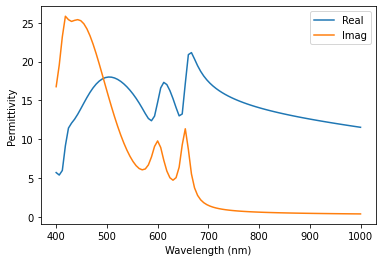

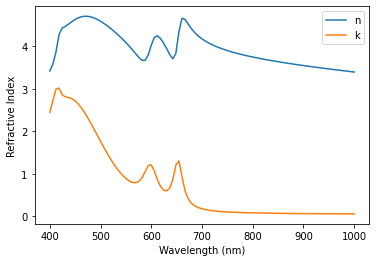

In [2]:
import numpy as np    
import matplotlib.pyplot as plt
#
lambdas = np.linspace(400e-9,1000e-9,100) # wavelengths
Ef = 0.0 # Fermi-Energy (eV), e.g. Ef = 0 means undoped, no-gate voltage
Temp = 300     # (K) temperature

# get complex permittivity
eps = getMoS2epsnk(lambdas,Ef,Temp)    

plt.figure(1)
plt.plot(lambdas*1e9,np.real(eps),label='Real')
plt.plot(lambdas*1e9,np.imag(eps),label='Imag')
plt.xlabel('Wavelength (nm)');
plt.ylabel('Permittivity');
plt.legend();    
plt.show()
    
# convert permittivity to refractive index    
n,k = eps2nk(eps)

plt.figure(2)
plt.plot(lambdas*1e9,n,label='n')
plt.plot(lambdas*1e9,k,label='k')
plt.xlabel('Wavelength (nm)');
plt.ylabel('Refractive Index');
plt.legend();    
plt.show()
